In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ift6758.training import AdvancedModel
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

In [3]:
train_val = pd.read_pickle('../../notebooks/Milestone2/TrainValSets.pkl')
X_all = train_val.drop(['is_goal'], axis=1)
y_all = train_val['is_goal']

train2_val = pd.read_pickle('../../notebooks/Milestone2/TrainValSets2.pkl')
X2_all = train2_val.drop(['is_goal'], axis=1)
y2_all = train2_val['is_goal']

# Split into train val
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_all, y2_all, test_size=0.3, random_state=42)


In [4]:
modelsDict = {
    'xgboost_distance-angle': AdvancedModel(pickle.load(open('../../train/xgboost_distance-angle/model.pkl', 'rb'))).get_pred_proba(X2_val[['distance_goal', 'angle_shot']])
    ,'xgboost_allFeatures': AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).get_pred_proba(X2_val[['period' ,'game_seconds' ,'x', 'y', 'empty_net', 'prev_x', 'prev_y', 'time_since_prev', 'distance_from_prev', 'distance_goal', 'prev_distance_goal', 'angle_shot', 'prev_angle_shot', 'bounce', 'angle_change', 'speed', 'shot_type_Deflected', 'shot_type_Slap_Shot' ,'shot_type_Snap_Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around', 'shot_type_Wrist_Shot', 'prev_type_FACEOFF', 'prev_type_GIVEAWAY', 'prev_type_GOAL', 'prev_type_HIT', 'prev_type_MISSED_SHOT', 'prev_type_PENALTY' ,'prev_type_SHOT' ,'prev_type_TAKEAWAY']])
}

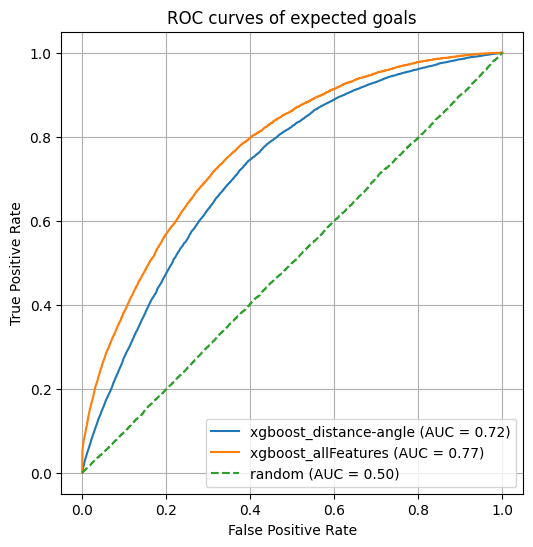

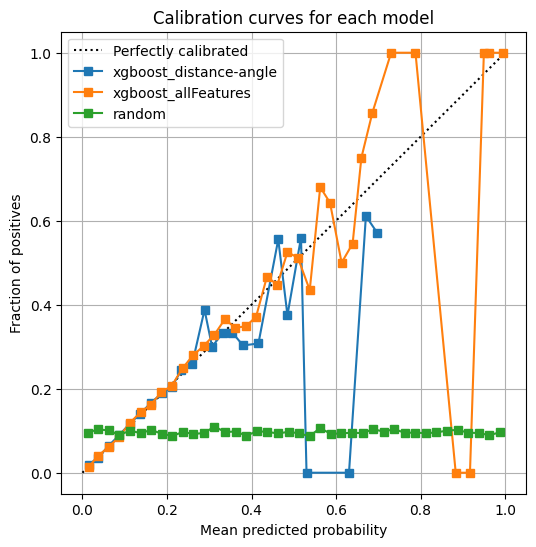

/Users/JJKaufman/DESS/IFT6758/IFT6758-A5-NHL/ift6758/training/plot.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate = df.groupby(centiles).is_goal.mean()


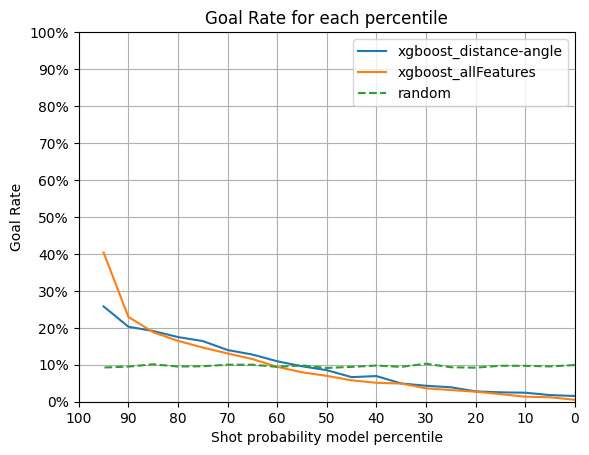

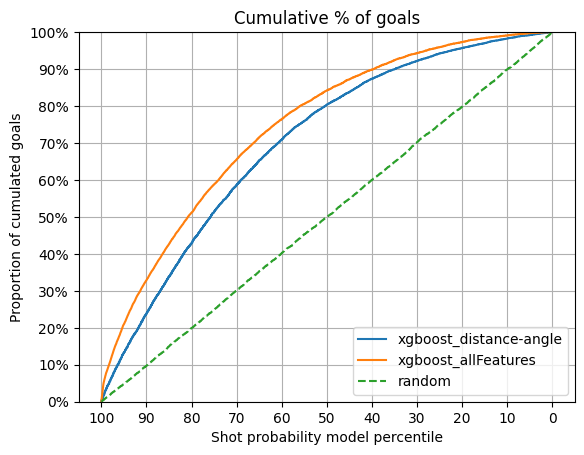

In [5]:
from ift6758.training.plot import plot_all
plot_all(modelsDict, y2_val)

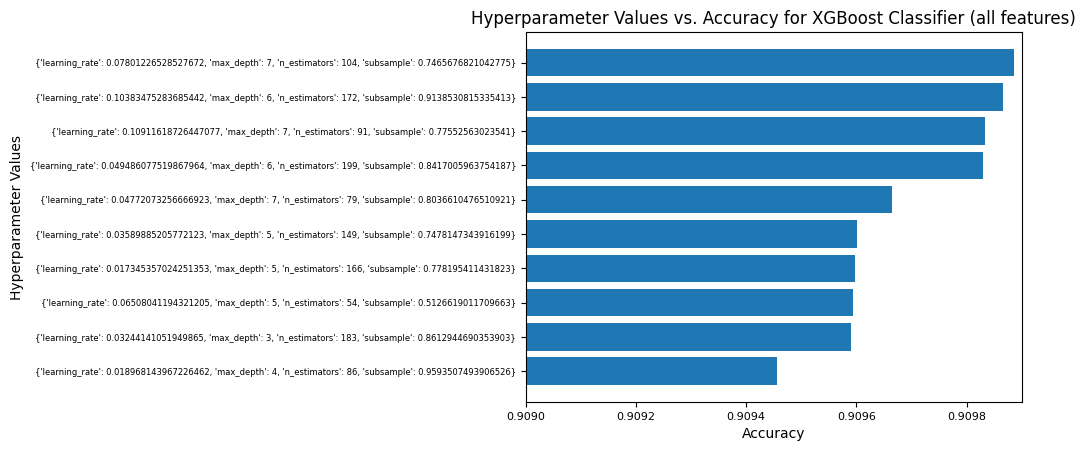

In [6]:
AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).hp_plot()

In [7]:
import matplotlib.pyplot as plt
y1 = AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).clf.feature_importances_
x1 = AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).clf.get_booster().feature_names

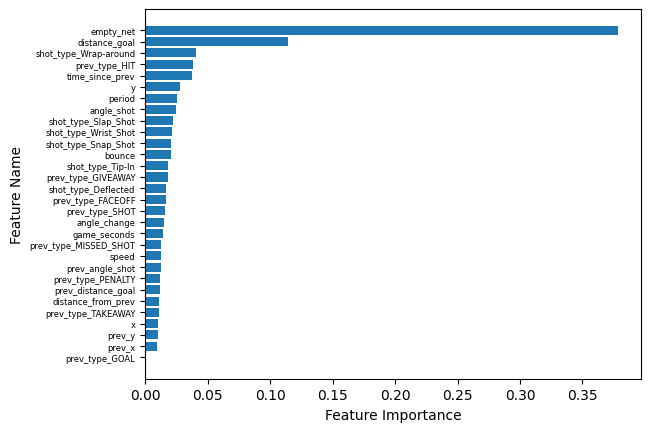

In [8]:
res = [list(i) for i in zip(*sorted(zip(y1, x1),
                                  key = lambda dual: dual[0]))]
x2 = res[1]
y2 = res[0]
plt.barh(x2, y2)
plt.yticks(range(len(x2)), x2, fontsize = 6)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()